In [2]:
#Imports
import pandas as pd
import numpy as np
from goatools.base import get_godag
from goatools.anno.gaf_reader import GafReader
from goatools.gosubdag.gosubdag import GoSubDag
from collections import defaultdict
#Get the GO terms
godag = get_godag("go-basic.obo", optional_attrs='relationship')
#Get the GO Annotation File
gogaf = GafReader("goa_yeast.gaf")
#Build pairs and sl columns in gene2sl
genes     = pd.read_csv('gsets_1', header=None, names=["genes"])
sl_lables = pd.read_csv('sl_1', header=None, names=["sl"])
gene2sl   = pd.concat([genes, sl_lables], axis=1)
#gene2sl   = gene2sl.set_index('genes')
#Now get a gene to GO id dict.
gene2goid = defaultdict(set)
for assoc in gogaf.associations:
    for syn in assoc.DB_Synonym:
        gene2goid[syn].add(assoc.GO_ID)

  EXISTS: go-basic.obo
go-basic.obo: fmt(1.2) rel(2019-10-07) 47,285 GO Terms; optional_attrs(relationship)
HMS:0:00:03.222482  91,452 annotations READ: goa_yeast.gaf 


In [25]:
dir(gogaf)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_get_1ns_assn',
 '_get_dbid2goids_p0',
 '_get_dbid2goids_p1',
 '_get_go2ancestors',
 '_get_goid2dbids',
 '_get_id2gos',
 '_get_namespaces',
 '_get_ns2ntsanno',
 '_has_not_qual',
 '_init_associations',
 '_prt_qualifiers',
 '_rpt_goids_notfound',
 'associations',
 'chk_associations',
 'chk_qualifiers',
 'datobj',
 'evobj',
 'exp_kws',
 'exp_nss',
 'exp_qualifiers',
 'filename',
 'get_associations',
 'get_dbid2goids',
 'get_desc',
 'get_goid2dbids',
 'get_id2gos',
 'get_id2gos_nss',
 'get_name',
 'get_ns2assc',
 'get_ns2ntsanno',
 'get_taxid',
 'godag',
 'has_ns',
 'hdr',
 'hms',
 'name',
 'namespaces',
 'nts_ev_nd',
 'nts_

In [36]:
dir(godag)

['__class__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_populate_relationships',
 '_populate_terms',
 '_set_level_depth',
 '_str_desc',
 'clear',
 'copy',
 'data_version',
 'draw_lineage',
 'fromkeys',
 'get',
 'id2int',
 'items',
 'keys',
 'label_wrap',
 'load_obo_file',
 'make_graph_pydot',
 'make_graph_pygraphviz',
 'paths_to_top',
 'pop',
 'popitem',
 'query_term',
 'setdefault',
 'typedefs',
 'update',
 'update_association',
 'values',
 'version',
 'write_dag']

In [14]:
term = godag.get('GO:0010468')
term

GOTerm('GO:0010468'):
  id:GO:0010468
  item_id:GO:0010468
  name:regulation of gene expression
  namespace:biological_process
  _parents: 1 items
    GO:0060255
  parents: 1 items
    GO:0060255	level-04	depth-04	regulation of macromolecule metabolic process [biological_process]
  children: 21 items
  level:5
  depth:5
  is_obsolete:False
  alt_ids: 0 items
  relationship: 1 items
    regulates: 1 items
      GO:0010467	level-04	depth-04	gene expression [biological_process]
  relationship_rev: 1 items
    part_of: 1 items
      GO:0023019	level-03	depth-05	signal transduction involved in regulation of gene expression [biological_process]
  reldepth:5

In [13]:
p1 = term.parents
p1

{GOTerm('GO:0060255'):
   id:GO:0060255
   item_id:GO:0060255
   name:regulation of macromolecule metabolic process
   namespace:biological_process
   _parents: 1 items
     GO:0019222
   parents: 1 items
     GO:0019222	level-03	depth-03	regulation of metabolic process [biological_process]
   children: 20 items
   level:4
   depth:4
   is_obsolete:False
   alt_ids: 0 items
   relationship: 1 items
     regulates: 1 items
       GO:0043170	level-03	depth-03	macromolecule metabolic process [biological_process]
   relationship_rev: 0 items
   reldepth:4}

In [43]:
%%prun
#Now build the hierarchy, meaning each node is represented by the no. of all its descendants
genes2terms = pd.DataFrame()
gene2terms = {}
for index, row in gene2sl.iterrows():
    for gene in row['genes'].split("$"):
        #No such gene, build it
        if gene not in gene2terms:
            gene2terms[gene] = {}
            genebiogoid = []
            go_ids = gene2goid.get(gene)
            if go_ids is None:
                print("Could not find the gene {} in GAF".format(gene))               
            else:
                for go_id in go_ids:
                    term = godag.get(go_id)
                    if term.namespace == 'biological_process':                     
                        #Get the leaf GO term
                        genebiogoid.append(go_id)  
                        if go_id not in gene2terms[gene]:
                            gene2terms[gene][go_id] = 1
                        else:
                            gene2terms[gene][go_id] += 1
            # Create a subset of the GO DAG which contains:
            # The common GO term that'is_a' for the gene, by setting relationships=False
            #print("genebiogoid: \n",genebiogoid)
            gosubdag = GoSubDag(genebiogoid, godag, relationships=False, prt=False) 
            ancestors = defaultdict(set)
            if go_id in gosubdag.rcntobj.go2parents:
                for p_go in gosubdag.rcntobj.go2parents[go_id]:
                    dict_anc = gosubdag.go2nt[p_go]._asdict()
                    ancestors[dict_anc['depth']].add(dict_anc['GO'])                            
            #Sum up all the ancestors values
            #print("ancestors: \n",ancestors)
            count_genes = 1  
            for level in range(len(ancestors) - 1, -1, -1):
                for GO in ancestors[level]:
                    if GO not in gene2terms[gene]:
                        gene2terms[gene][GO] = count_genes
                    else:
                        gene2terms[gene][GO] += count_genes                                
                count_genes += len(ancestors[level])                          
    #Build the combination of the 2 genes
    g1, g2 = row['genes'].split("$")
    gene1 = gene2terms[g1]
    gene2 = gene2terms[g2]         
    genesdict = {key: gene1.get(key, 0) + gene2.get(key, 0)
                 for key in set(gene1) | set(gene2)}
    genesdict['genes'] = row['genes']
    genesdict['sl'] = row['sl']
    #Add the final line and clean NaN
    genes2terms = genes2terms.append(genesdict, ignore_index=True)
    genes2terms = genes2terms.fillna(0)
    #break
    #print(index)
    if index == 100: break

In [44]:
genes2terms

,GO:0006325,GO:0006338,GO:0006623,GO:0006810,GO:0007029,GO:0007034,GO:0008150,GO:0009987,GO:0016043,GO:0016192,...,GO:0000301,GO:0006890,GO:0006895,GO:0032482,GO:0006906,GO:0048279,GO:0048280,GO:0000272,GO:0000920,GO:0006032
0,5.0,4.0,1.0,8.0,1.0,5.0,22.0,8.0,7.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,8.0,0.0,5.0,12.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7.0,1.0,1.0,8.0,0.0,5.0,24.0,10.0,9.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,8.0,0.0,5.0,12.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,8.0,0.0,5.0,12.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,0.0,0.0,1.0,8.0,0.0,5.0,12.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,0.0,0.0,1.0,8.0,0.0,5.0,12.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,0.0,0.0,1.0,8.0,0.0,5.0,12.0,0.0,0.0,5.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
99,0.0,0.0,1.0,8.0,0.0,5.0,12.0,0.0,0.0,5.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0


In [9]:
v2_g2t

,GO:0006325,GO:0006338,GO:0006605,GO:0006623,GO:0006810,GO:0006886,GO:0006996,GO:0007029,GO:0007034,GO:0008104,...,GO:0071702,GO:0071705,GO:0071824,GO:0071840,GO:0071985,GO:0072594,GO:0072665,GO:0072666,genes,sl
0,6.0,4.0,1.0,1.0,24.0,2.0,1.0,1.0,15.0,16.0,...,10.0,10.0,3.0,14.0,2.0,5.0,5.0,3.0,YAL002W$YAL011W,0.0


In [ ]:
genes2terms = pd.DataFrame()
gene2terms = {}
for index, row in gene2sl.iterrows():
    genebiogoid = []
    for gene in row['genes'].split("$"):
        #No such gene, build it
        if gene not in gene2terms:
            go_ids = gene2goid.get(gene)
            if go_ids is None:
                print("Could not find the gene {} in GAF".format(gene))               
            else:
                for go_id in go_ids:
                    term = godag.get(go_id)
                    if term.namespace == 'biological_process':
                        #Get the leaf GO term
                        genebiogoid.append(go_id)                        
            #Build the combination of the 2 genes
            # Create a subset of the GO DAG which contains:
            # The selected GO term and the 'is_a' GO terms above it, by setting relationships=False
            gene2terms[gene] = {}
            gosubdag = GoSubDag(genebiogoid, godag, relationships=False, prt=False) 
            ancestors = defaultdict(set)
            for p_genegoid in genebiogoid:
                count_genes = 1 
                if p_genegoid not in genesdict:
                    gene2terms[p_genegoid] = count_genes
                else:
                    gene2terms[p_genegoid] += count_genes 
                if p_genegoid in gosubdag.rcntobj.go2parents:
                    for p_go in gosubdag.rcntobj.go2parents[p_genegoid]:
                            dict_anc = gosubdag.go2nt[p_go]._asdict()
                            ancestors[dict_anc['depth']].add(dict_anc['GO'])
                #Sum up all the ancestors values
            for level in range(len(ancestors) - 1, -1, -1):
                for GO in ancestors[level]:
                    if GO not in genesdict:
                        gene2terms[GO] = count_genes
                    else:
                        gene2terms[GO] += count_genes                                
                    count_genes += len(ancestors[level])  
    g1, g2 = row['genes'].split("$")
    gene1 = gene2terms[g1]
    gene2 = gene2terms[g2]         
    genesdict = {key: gene1.get(key, 0) + gene2.get(key, 0)
                 for key in set(gene1) | set(gene2)}
    genesdict['genes'] = row['genes']
    genesdict['sl'] = row['sl']
    #Add the final line and clean NaN
    genes2terms = genes2terms.append(genesdict, ignore_index=True)
    genes2terms = genes2terms.fillna(0)
    break
    print(index)
    if index == 100: break

<IPython.core.display.Javascript object>


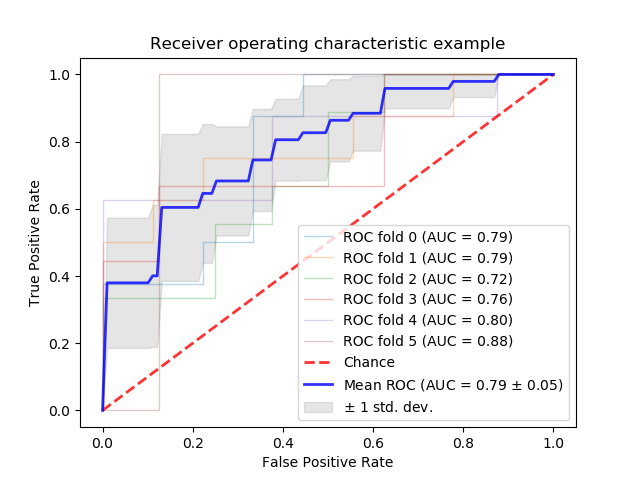

In [4]:
%matplotlib notebook
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold

# #############################################################################
# Data IO and generation

# Import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target
X, y = X[y != 2], y[y != 2]
n_samples, n_features = X.shape

# Add noisy features
random_state = np.random.RandomState(0)
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=6)
classifier = svm.SVC(kernel='linear', probability=True,
                     random_state=random_state)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    viz = plot_roc_curve(classifier, X[test], y[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")
plt.show()

In [1]:
import sklearn

print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.22.


In [ ]:
#pip install -U scikit-learn

In [3]:
from goatools.godag.go_tasks import get_go2parents

GO_ID = 'GO:0008150'  # regulation of metabolic process - 0019222
optional_relationships = set()
go2parents_isa = get_go2parents(godag, optional_relationships)
print(go2parents_isa)

ImportError: cannot import name 'get_go2parents' from 'goatools.godag.go_tasks' (/Users/iftahperetz/opt/anaconda3/lib/python3.7/site-packages/goatools-0.9.9-py3.7.egg/goatools/godag/go_tasks.py)

In [26]:
def ppp():
    print(godag['GO:0008150'])

In [38]:
tmp_gosubdag = GoSubDag('GO:0048522', godag, relationships=False, prt=False)
tmp_gosubdag.rcntobj.go2parents['GO:0048522']

{'GO:0008150', 'GO:0048518', 'GO:0050789', 'GO:0050794', 'GO:0065007'}

In [57]:
def build_godag_isa():
        #Now build the hierarchy, meaning each node is represented by the no. of all its descendants
    genes2terms = pd.DataFrame()
    gene2terms = {}
    for index, row in gene2sl.iterrows():
        for gene in row['genes'].split("$"):
            #No such gene, build it
            if gene not in gene2terms:
                go_ids = gene2goid.get(gene)
                if go_ids is None:
                    print("Could not find the gene {} in GAF".format(gene))               
                else:
                    gene2terms[gene] = {}
                    for go_id in go_ids:
                        #go_id = 'GO:0048522'
                        term = godag.get(go_id)
                        if term.namespace == 'biological_process':
                            # Create a subset of the GO DAG which contains:
                            # The selected GO term and the 'is_a' GO terms above it, by setting relationships=False
                            gosubdag = GoSubDag(go_id, godag, relationships=False, prt=False) 
                            ancestors = defaultdict(set)
                            if go_id in gosubdag.rcntobj.go2parents:
                                for p_go in gosubdag.rcntobj.go2parents[go_id]:
                                    dict_anc = gosubdag.go2nt[p_go]._asdict()
                                    ancestors[dict_anc['depth']].add(dict_anc['GO'])
                            #print(ancestors)       
                            #Get the leaf GO term
                            if go_id not in gene2terms[gene]:
                                gene2terms[gene][go_id] = 1
                            else:
                                gene2terms[gene][go_id] += 1
                            #Sum up all the ancestors values
                            count_genes = 1  
                            for level in range(len(ancestors) - 1, -1, -1):
                                for GO in ancestors[level]:
                                    if GO not in gene2terms[gene]:
                                        gene2terms[gene][GO] = count_genes
                                    else:
                                        gene2terms[gene][GO] += count_genes                                
                                count_genes += len(ancestors[level])  

        #Build the combination of the 2 genes
        g1, g2 = row['genes'].split("$")
        gene1 = gene2terms[g1]
        gene2 = gene2terms[g2]             
        genesdict = {key: gene1.get(key, 0) + gene2.get(key, 0)
                     for key in set(gene1) | set(gene2)}
        #print(genesdict)
        genesdict['genes'] = row['genes']
        genesdict['sl'] = row['sl']
        #Add the final line and clean NaN
        genes2terms = genes2terms.append(genesdict, ignore_index=True)
        genes2terms = genes2terms.fillna(0)
        #print(genes2terms)
        #break
        if index == 10: break

In [58]:
%prun build_godag_isa()

In [59]:
genes2terms

,genes,sl
0,YAL002W$YAL011W,0.0
1,YAL002W$YAL013W,0.0
2,YAL002W$YAL019W,0.0
3,YAL002W$YAL021C,0.0
4,YAL002W$YAL058W,0.0
...,...,...
996,YAL013W$YJL139C,0.0
997,YAL013W$YJL148W,0.0
998,YAL013W$YJL154C,0.0
999,YAL013W$YJL166W,0.0


In [60]:
import numpy as np
outfile = 'mnmc_lite.features.npz'
npzfile = np.load(outfile)

In [61]:
npzfile.files

['features', 'overlay_features']

In [68]:
npzfile['features'].shape

(134275, 5)

In [67]:
npzfile['overlay_features'].shape

(134275, 10)